In [1]:
# use widgets as matplotlib backend
%matplotlib widget

# imports
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from collections import defaultdict
from time import time
from tqdm.auto import tqdm #progress bar, auto selects a backend based on the environment e.g. for a jupyter notebook it will use the widget version

from typing import Union, Tuple

import matplotlib as mpl

# import the file object for opening kongsberg files
# Note: function and library naming to be discussed
from themachinethatgoesping.echosounders import kongsbergall          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import pingtools          # This is the filereader module for .all/.wcd files
from themachinethatgoesping.echosounders import index_functions # This is the module for creating and using indexes to speed up file initialization
import themachinethatgoesping.tools as ptools                   # Some tools for working with ping (here we use timeconv for timestamp conversion)
import themachinethatgoesping.algorithms as palgorithms                   # Some tools for working with ping (here we use timeconv for timestamp conversion)
gp = palgorithms.geoprocessing

# simplify creating figures
mpl.rcParams['figure.dpi'] = 100
close_plots: bool = True

def create_figure(name: str, return_ax: bool = True) -> Union[Tuple[plt.Figure, plt.Axes], plt.Figure]:
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

In [2]:
directory = '/home/'

In [3]:
import ipywidgets as widgets
import solara

filewidget = solara.FileBrowser.widget(directory=directory, on_file_open=print)

widgets.VBox(
    children=[
        filewidget
    ]
)

In [4]:
try:
    directory = filewidget.directory_change
except:
    directory = filewidget.directory
files = index_functions.find_files([directory], [".all",'wcd'])

removing duplicates:   6%|5         | 31/552 [00:01<00:19, 26.77it/s]

Found 560 files + 109 duplicates (discarded)


Open all files
The function 
Notes: 
1. em3000.FileEM3000_mapped(files) scanns and indexes all files and provides access to all files like a combined file stream
2. If a .all and a .wcd files with the same name (one .all and one .wcd) are added, they will be matched to a single file
3. It is not possible to add two .all or two .wcd with the same name, even if they are within different folders
4. Note: if the files are not sorted in time, the datagram packages will not be sorted by time either, however it isi simple to sort the pings at a later stage

In [5]:
# This code creates a folder called 'index', where an index file for each folder where a .all or .wcd file was found is stored.
# The index files are created later. If you previously run this notebook already, 
# the cached_index will speed up the initialization of KongsbergAllFileHandler (next cell)

cached_index = index_functions.load_index_files(file_paths=files)

In [7]:

fm = kongsbergall.KongsbergAllFileHandler_mapped(files[:], cached_index, init=True)

WARNING(InputFileHandler): File [0] read incompletely. [...6da23ec7e/files/grass78/scripts/v.db.reconnect.all]
Stopped after 0.00 % of the file
Error message: KongsbergAllDatagram: start identifier is not 0x02, but 0x73
WARNING(InputFileHandler): File [1] read incompletely. [...calhost/usr/lib/grass83/scripts/v.db.reconnect.all]
Stopped after 0.00 % of the file
Error message: KongsbergAllDatagram: start identifier is not 0x02, but 0x75
WARNING(InputFileHandler): File [2] read incompletely. [...6186da23ec7e/files/grass78/scripts/g.extension.all]
Stopped after 0.00 % of the file
Error message: KongsbergAllDatagram: start identifier is not 0x02, but 0x73
WARNING(InputFileHandler): File [3] read incompletely. [.../localhost/usr/lib/grass83/scripts/g.extension.all]
Stopped after 0.00 % of the file
Error message: KongsbergAllDatagram: start identifier is not 0x02, but 0x75
WARNING(InputFileHandler): File [4] read incompletely. [...9a0c6186da23ec7e/files/grass78/scripts/v.build.all]
Stopped a

In [34]:
# save the index of fm to disk for later reuse
# Note(1): At this moment only the datagram index is saved. 
#          This means that the navigation data and the pings still have to be initialized when opening KongsbergAllFileHandler
#          In the future we will save more information to further speed up the file loading process
# Note(2): The index is saved in a folder called index in the current working directory
# Note(3): If you restart the notebook after executing this cell you should notice that KongsbergAllFileHandler will load much faster

index_functions.update_index_files(fm.get_cached_file_index())

In [35]:
from importlib import reload

import themachinethatgoesping.pingprocessing.watercolumn.make_image as mi
import themachinethatgoesping.pingprocessing.watercolumn.helper.make_image_helper as mi_hlp
reload(mi_hlp)
reload(mi)

<module 'themachinethatgoesping.pingprocessing.watercolumn.make_image' from '/ssd/src/themachinethatgoesping/themachinethatgoesping/subprojects/meta/..//pingprocessing/python/themachinethatgoesping/pingprocessing/watercolumn/make_image/__init__.py'>

In [36]:
from collections import OrderedDict

def group_dual_pings(pings):
    transducers = set()
    ping_groups = []
    ping_group_map = {}
    for ping in tqdm(pings):        
        key = (ping.get_file_nr(),ping.get_file_ping_counter())
        
        if key not in ping_group_map:
            ping_group_map[key] = len(ping_groups)
            ping_groups.append(OrderedDict())
            transducers.add(ping.get_channel_id())
            
        ping_groups[ping_group_map[key]][ping.get_channel_id()] = ping
            
    return ping_groups, transducers
            
ping_groups, transducers = group_dual_pings(fm.pings().get_sorted_by_time())
print(f"{len(ping_groups)}/{len(fm.pings())} ping groups")
print(transducers)

  0%|          | 0/55901 [00:00<?, ?it/s]

27951/55901 ping groups
{'TRX-2004', 'TRX-2031'}


In [37]:
class fake_tqdm(object):
    def __init__(self, w_prg):
        self.w_prg = w_prg
        
    def __call__(self, list_like):
        self.list_like = list_like
        self.list_iter = iter(list_like)
        self.index = 0
        self.total = len(list_like)
        self.w_prg.max = self.total
        self.w_prg.value = 0
        return self
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.index += 1
        self.w_prg.value = self.index
        return next(self.list_iter)
    
    def __len__(self):
        return self.total
    
    def update(self):
        self.index += 1
        next(self.list_iter)
        self.w_prg.value = self.index
        
    def close(self):
        pass

## Extract and plot navigation data
1. The navigation interface is not yet ready, but we can already get the navigation of each transducer and put it into a list

In [38]:
all_pings = fm.pings().split_by_features(["watercolumn"])[0].get_sorted_by_time()

#all_pings = all_pings.split_by_features(["bottom"])[0]
print(len(all_pings),"/",len(fm.pings()))

ping_containers = all_pings.split_by_time_diff(60 * 15)

ping_containers = [p for p in ping_containers if len(p) > 100]

for i,c in enumerate(ping_containers):
    print(f"{i}: {len(c)}")
    

52737 / 55901
0: 52737


In [29]:
lat = []
lon = []
time = []
nav_locations = defaultdict(list)
for i, pings in enumerate(ping_containers):
    for p in tqdm(pings):
        try:
            # we just use the location of the first transduce rhere
            g = p.get_geolocation()
            lat.append(g.latitude)
            lon.append(g.longitude)
            time.append(p.get_timestamp())
            nav_locations[i].append([g.latitude,g.longitude])
        except Exception as e:
            print(e)
            break


  0%|          | 0/52737 [00:00<?, ?it/s]

In [30]:
for i,c in enumerate(ping_containers):
    print(f"{i}: {len(c)}")

0: 52737


In [31]:
# This code uses ipyleaflet for plotting the navigaiton data on background map (needs internet)
# the code is thus unreleated to ping

from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, projections, Marker, AwesomeIcon
from ipywidgets import Layout, HTML
from matplotlib import colormaps,colors

cmap = colormaps.get_cmap("tab20")

m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.NatGeoWorldMap),
    center=(np.nanmedian(lat), np.nanmedian(lon)),
    layout=Layout(width='80%', height='600px'),
    zoom=9,
    crs=projections.EPSG3857
)

for k,n in nav_locations.items():
    ant_path = AntPath(
        locations=n,
        # dash_array=[1, 10],
        # delay=1000,
        color=colors.to_hex(cmap(k))
        # pulse_color='#3f6fba'
    )

    m.add(ant_path)

    icon = AwesomeIcon(
        name='ship',
        marker_color="white",
        icon_color=colors.to_hex(cmap(k)),
        #spin=True
        )
    marker = Marker(
        location = n[0],
        icon=icon,
        title=str(k)
    )
    message = HTML()
    message.value = str(k)
    marker.popup = message

    m.add(marker)


# marker = Marker(location = nav_locations[2][16764])
# m.add(marker)
# marker = Marker(location = nav_locations[2][17422])
# m.add(marker)
# marker = Marker(location = nav_locations[2][17730])
# m.add(marker)
try:
    from localtileserver import get_leaflet_tile_layer, TileClient

    client = TileClient(background_map_path)
    t = get_leaflet_tile_layer(client,band=1,cmap="YlGnBu_r")
    m.add_layer(t)
except Exception as e:
    print(e)
    print("no background map")

m


name 'background_map_path' is not defined
no background map


Map(center=[51.361942008760444, 3.1258601895595532], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [32]:
I = np.array(range(6,len(ping_containers),1))
I = np.array(range(0,len(ping_containers),1))
I = [3]

In [33]:
pings=[]
for i in I:
    pings.extend([p for p in ping_containers[i].get_sorted_by_time()])
for ping in tqdm(pings):
   ping.load()

ping_groups, transducers = group_dual_pings(pings)
print(transducers, len(ping_groups), '/', len(pings))

IndexError: list index out of range

## make Echogram

  0%|          | 0/18092 [00:00<?, ?it/s]

  0%|          | 0/18092 [00:00<?, ?it/s]

/tmp/ipykernel_63748/3739155939.py:81: RuntimeWarning: Mean of empty slice
  data[i][:] = np.nanmean(A,axis=0)


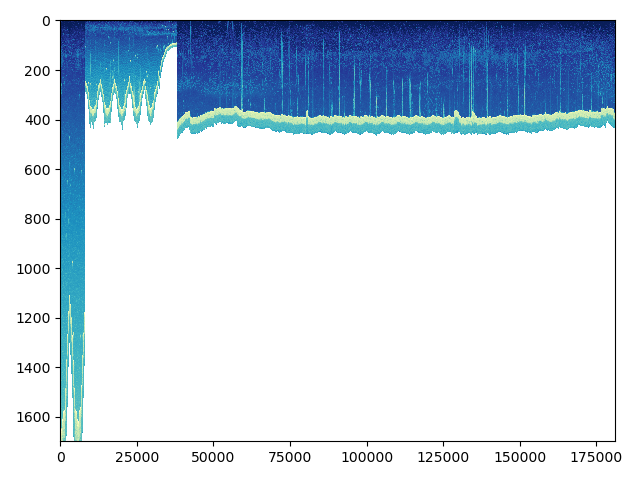

In [30]:
#set the beam angle range in degrees
beam_angle_min = -20
beam_angle_max = 20
beam_step = 2
sample_step = 1
ping_step = 10
ping_start = None
ping_stop = None
max_samples = 1700
linear_mean = True


#first loop, get statistics
max_s_pnr = 0
max_s = 0
frequencies = {}

#bss = pingtools.BeamSampleSelection(sample_step_ensemble=sample_step)
pss = pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(beam_angle_min,beam_angle_max, beam_step)
pss.select_sample_range_by_numbers(0, max_samples, sample_step)
pss.set_sample_step(sample_step)

for i,pg in enumerate(tqdm(ping_groups[ping_start:ping_stop:ping_step])):
    for p in pg.values():
        try:
            sel = pss.apply_selection(p)

            p.watercolumn.get_beam_crosstrack_angles(sel)
            num_s = np.max(p.watercolumn.get_number_of_samples_per_beam(sel))

            if num_s > max_s:
                max_s = num_s
                max_s_pnr = i
                
        except IndexError as e:
            print("error:",i,e,"|",type(e))
        except ValueError as e:
            print("error:",i,e,"|",type(e))
        except RuntimeError as e:
            print("error:",i,e,"|",type(e))

if max_s > pss.get_max_sample_number():
    max_s = pss.get_max_sample_number()


data = np.empty((len(ping_groups[ping_start:ping_stop:ping_step]),max_s))
data.fill(np.nan)
index = 0


for i,pg in enumerate(tqdm(ping_groups[ping_start:ping_stop:ping_step])):
    #sel = pss.apply_selection(p)
    A=[]
    for p in pg.values():
        try:
            rt = gp.raytracers.RTConstantSVP(p.get_geolocation(),1450)
            sel = pss.apply_selection(p)
            r = p.raw_data
            
                        
            samples = p.watercolumn.get_amplitudes(sel)
            if linear_mean:
                samples = np.power(10,0.1*samples)
            
            index += 1

            m = min(samples.shape[1], max_s)
            a = data[i].copy()
                        
            a[:m] = np.nanmean(samples,axis=0)[:m]
            A.append(a)
    
        except IndexError as e:
            print("error:",i,e,"|",type(e))
        except ValueError as e:
            print("error:",i,e,"|",type(e))
        except RuntimeError as e:
            print("error:",i,e,"|",type(e))
            
    data[i][:] = np.nanmean(A,axis=0)

if linear_mean:
    data = 10*np.log10(data)

fig,ax = create_figure("test")

#ax.imshow(data.transpose(),aspect='auto',cmap='YlGnBu_r',vmin=-80, vmax = -30, interpolation='nearest')
if ping_stop == None: ping_stop = len(ping_groups)
if ping_start == None: ping_start = 0
ax.imshow(data.transpose(),aspect='auto',cmap='YlGnBu_r',interpolation='nearest', extent = [-0.5+ping_start,ping_stop+0.5,data.shape[1]+0.5, -0.5])
ax.set_ylim(data.shape[1],0)
fig.set_tight_layout(True)

In [31]:
def trace_ping(ping, mp_cores=1):
    sc = ping.get_sensor_configuration()
    pingoff = sc.get_target("Transducer")
    posoff = sc.get_position_source()
    geolocation = ping.get_geolocation()

    rt_bottom,dr, bottom_samples = mi_hlp.get_bottom_directions_wci(ping)
    minslant_sample = np.nanmin(bottom_samples[bottom_samples>100]) - 5

    RT = gp.raytracers.RTConstantSVP(geolocation,1450)
    rt_wci = RT.trace_swath(
        0,
        minslant_sample,
        1, 
        ping.watercolumn.get_sample_interval(),
        0.,
        ping.watercolumn.get_beam_alongtrack_angles(),
        ping.watercolumn.get_beam_crosstrack_angles(),
        mp_cores=mp_cores
    )

    return rt_bottom, rt_wci, minslant_sample


In [32]:

pss = pingtools.PingSampleSelector()
pss.select_sample_range_by_numbers(0, minslant_sample-1, 1)
sel = pss.apply_selection(ping)

ping.watercolumn.get_amplitudes(sel).shape

NameError: name 'minslant_sample' is not defined

In [ ]:
fd = defaultdict(int)
for pings in tqdm(ping_groups[28000:32000]):
    for k,ping in pings.items():
        fd[ping.get_file_path()] += ping.watercolumn.get_number_of_samples_per_beam()

for k,v in fd.items():
    print(k,v)

In [ ]:
import pandas as pd

x = []
y = []
z = []
amps = []

bx = []
by = []
bz = []

for pings in tqdm(ping_groups[28000:32000]):
    results = gp.datastructures.RaytraceResults_2()
    for k,ping in pings.items():
        rt_bottom,rt_wci,minslant_sample = trace_ping(ping,8)
        pss = pingtools.PingSampleSelector()
        pss.select_sample_range_by_numbers(0, minslant_sample-1, 1)
        sel = pss.apply_selection(ping)

        amp = ping.watercolumn.get_amplitudes(sel)
        
        assert rt_bottom.shape()[0] == amp.shape[0]
        assert rt_wci.shape()[0] == amp.shape[0]
        assert rt_wci.shape()[1] == amp.shape[1]

        index = np.nonzero(amp > -40)
        amps.append(amp[index])
        x.append(rt_wci.x[index])
        y.append(rt_wci.y[index])
        z.append(rt_wci.z[index])

        bx.append(rt_bottom.x)
        by.append(rt_bottom.y)
        bz.append(rt_bottom.z)


In [ ]:
# import numpy as np
# with open("wci.txt", "w") as f:
#     for x_,y_,z_,amp_ in tqdm(zip(x,y,z,amps),total=len(x)):
        
#         # combine the x, y, z, and amps lists into a single numpy array
#         data = np.column_stack((x_, y_, z_, amp_))

#         # write the data to a text file
#         np.savetxt(f, data)

import numpy as np
with open("bottom.txt", "w") as f:
    for x_,y_,z_ in tqdm(zip(bx,by,bz),total=len(x)):
        
        # combine the x, y, z, and amps lists into a single numpy array
        data = np.column_stack((x_, y_, z_))

        # write the data to a text file
        np.savetxt(f, data)
    

## make waterfall

In [34]:
def get_min_slant_range_sample(ping):
    bs = ping.watercolumn.get_bottom_range_samples()
    return np.nanmin(bs[bs > 50])

  0%|          | 0/3619 [00:00<?, ?it/s]

  0%|          | 0/3619 [00:00<?, ?it/s]

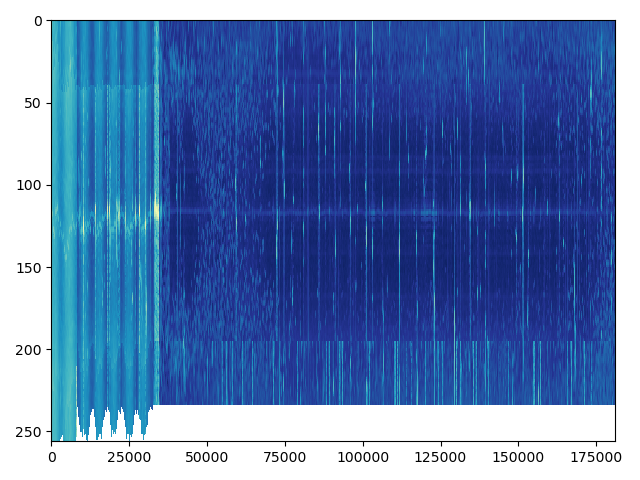

In [35]:
#set the beam angle range in degrees
beam_angle_min = -60
beam_angle_max = 60
beam_step = 1
sample_step = 1
ping_step = 50
ping_start = None
ping_stop = None
linear_mean=True


#first loop, get statistics
max_b = 0
frequencies = {}

#bss = pingtools.BeamSampleSelection(sample_step_ensemble=sample_step)
pss = pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(beam_angle_min,beam_angle_max, beam_step)
pss.set_sample_step(sample_step)

pss_left = pss.copy()
pss_right = pss.copy()

# pss_left.select_beam_range_by_angles(beam_angle_min,0, beam_step)
# pss_right.select_beam_range_by_angles(0,beam_angle_max, beam_step)

for i,pg in enumerate(tqdm(ping_groups[ping_start:ping_stop:ping_step])):
    num_b = 0
    for p in pg.values():
        
        if (len(pg.values()) > 1):
            ba = p.watercolumn.get_beam_crosstrack_angles()
            # detect left or right swath
            if np.nanmean(ba) < 0: 
                sel = pss_left.apply_selection(p)
            else:         
                sel = pss_left.apply_selection(p)       
        else:
            sel = pss.apply_selection(p)

        num_b += len(p.watercolumn.get_beam_crosstrack_angles(sel))
            
    max_b = max(max_b,num_b)
                

data = np.empty((len(ping_groups[ping_start:ping_stop:ping_step]),max_b))
data.fill(np.nan)
index = 0


prg = tqdm(ping_groups[ping_start:ping_stop:ping_step])
for pn,pg in enumerate(prg):
    try:
        first_bn=0
        amp_left = None
        amp_right = None
        
        for ping in pg.values():  
            left=True
            if (len(pg.values()) > 1):                
                ba = ping.watercolumn.get_beam_crosstrack_angles()
                # detect left or right swath
                if np.nanmean(ba) < 0: 
                    sel = pss_left.apply_selection(ping)
                    left=False
                else: 
                    sel = pss_right.apply_selection(ping)
            else:
                sel = pss.apply_selection(ping)            
            
            min_slant = get_min_slant_range_sample(ping)
            min_s = min_slant - 100
            if min_s < 0:
                min_s = 0

            sel.set_first_sample_number_ensemble(min_s)
            sel.set_last_sample_number_ensemble(min_slant-20)
            #sel.set_first_sample_number_ensemble(min_slant)
            #sel.set_last_sample_number_ensemble(min_slant+100)
            
            amp = ping.watercolumn.get_amplitudes(sel)
            if linear_mean:
                amp = np.power(10,0.1*amp)
            amp = np.nanmean(amp,axis=1)
            
            if left:
                amp_left = amp
            else:
                amp_right = amp
                
        
        data[pn][:len(amp_left)] = amp_left
        
        if amp_right is not None:
            data[pn][len(amp_left):len(amp_left)+len(amp_right)] = amp_right
        
    except Exception as e:
        print(e)

if linear_mean:
    data = 10*np.log10(data)

fig,ax = create_figure("waterfall")

#ax.imshow(data.transpose(),aspect='auto',cmap='YlGnBu_r',vmin=-80, vmax = -30, interpolation='nearest')
if ping_stop == None: ping_stop = len(ping_groups)
if ping_start == None: ping_start = 0
ax.imshow(data.transpose(),aspect='auto',cmap='YlGnBu_r',interpolation='nearest', extent = [-0.5+ping_start,ping_stop+0.5,data.shape[1]+0.5, -0.5])
ax.set_ylim(data.shape[1],0)
fig.set_tight_layout(True)

In [36]:
if False:
    tmp_accumulator = 0
    ax.axvline(0,color='r',alpha=0.5)
    ax.text(0,0,str(0),rotation=90,verticalalignment='bottom',horizontalalignment='center')
    for i in I:
        pc = ping_containers[i]
        tmp_accumulator += len(pc)/2
        print(tmp_accumulator)
        ax.axvline(tmp_accumulator,color='r',alpha=0.5)
        ax.text(tmp_accumulator,0,str(i+1),rotation=-90,verticalalignment='bottom',horizontalalignment='center')

In [37]:
last_file_nr = -1
for i,pg in enumerate(ping_groups):
    for ping in pg.values():
        if ping.get_file_nr() != last_file_nr:
            ax.axvline(i,color='grey',alpha=0.3,linestyle='--', linewidth=0.5)
            last_file_nr = ping.get_file_nr()
    

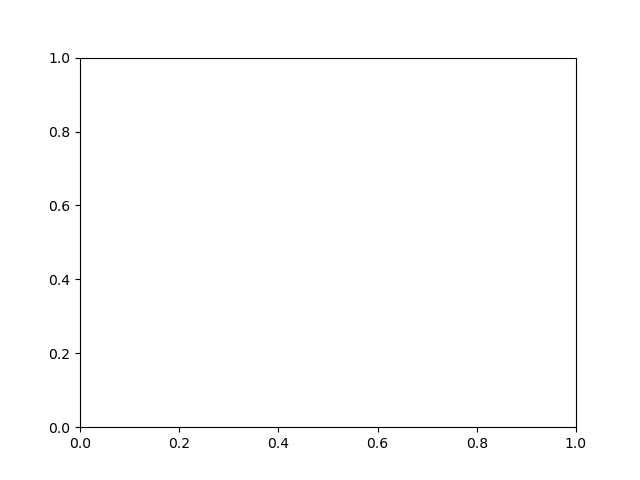

In [38]:
fig_wci, ax_wci = create_figure("wci")

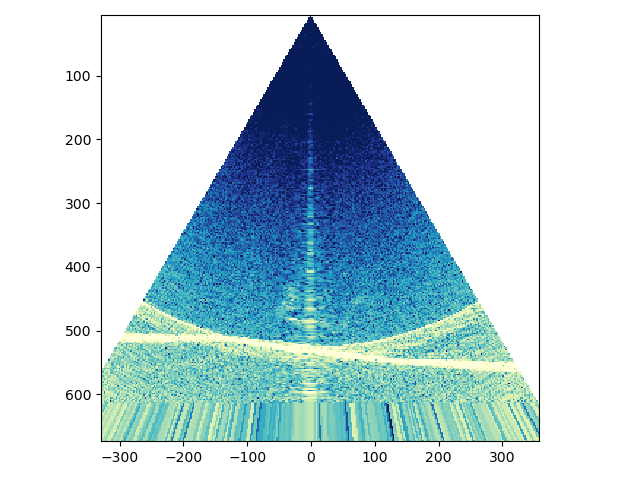

IntProgress(value=0, description='Stacking:', max=10)

FloatSlider(value=-1.0, max=50.0, min=-1.0, step=1.0)

FloatSlider(value=-50.0, max=150.0, min=-150.0, step=5.0)

FloatSlider(value=50.0, max=150.0, min=-150.0, step=5.0)

IntSlider(value=0, max=180915)

IntSlider(value=300, max=2048, min=1)

In [39]:
from ipywidgets import *
from time import time

#ping_groups, transducers = group_dual_pings(fm.pings().get_sorted_by_time())

fig_wci.set_tight_layout(True)

last_split_plot = 100

#@widgets.interact
#@debounce(0.1)
def update(w):  
    try:
        if w_protect_stack.value:
            if w['owner'] != w_wci_stack:
                if float(w_text_execution_time.value) > 0.5:
                    w_wci_stack.value = w_wci_stack.value * 0.5 / float(w_text_execution_time.value)
        if w_wci_stack.value > 1:
            w_wci.step = int(w_wci_stack.value/2)
    except Exception as e:
        pass
    
    w_text_num_total.value = str(int(w_text_num_total.value) +1)
    w_text_num_active.value = str(int(w_text_num_active.value) +1)
    
    t = time()
    global a, last_split_plot, ax_wci, fig_wci, ping1, ping2
    a = w
    #print(w)
    wci_index = w_wci.value
    wci_stack = w_wci_stack.value
    wci_stack_step = w_wci_stack_step.value
    cmin = w_cmin.value
    cmax = w_cmax.value
    aspect = w_aspect.value
    hsize = w_hsize.value
    heads = w_heads.value
    interpolation = w_interpolation.value
    maxz = w_z.value
    from_bottom = w_from_bottom.value
    threshold_white = w_threshold.value
    linear_mean = w_linear_stack.value
     
    ping_group = ping_groups[wci_index]
    
    if wci_stack > 1:
        max_index = wci_index+wci_stack
        if max_index > len(ping_groups):
            max_index = len(ping_groups)
        pings = []
        for pp in ping_groups[wci_index:max_index:wci_stack_step]:
            for p in pp.values():
                pings.append(p)
                
        #pings = pings[::2]
    

    try:
        if wci_stack > 1:
            wci,extent = mi.make_wci_stack(pings,hsize,progress_bar=progress_bar,linear_mean=linear_mean,from_bottom_xyz=from_bottom)
            split_plot=False
        elif len(ping_group) == 1:
            ping = list(ping_group.values())[0]
            split_plot=False
            if heads == 'split_dual_rect':
                wci = ping1.watercolumn.get_amplitudes()
                extent = [0, ping.watercolumn.get_number_of_beams(),0, ping.watercolumn.get_number_of_samples_per_beam()[0]]
            else:
                wci,extent = mi.make_wci(ping,hsize,from_bottom_xyz=from_bottom)
        else:        
            ping1 = ping_group['TRX-2004']
            ping2 = ping_group['TRX-2031']
            if heads == 'blend_dual':
                wci,extent = mi.make_wci_dual_head(ping1,ping2,hsize,from_bottom_xyz=from_bottom)
                split_plot=False
            if heads == 'blend_dual_inverw_wci_stackse':
                wci,extent = mi.make_wci_dual_head(ping2,ping1,hsize,from_bottom_xyz=from_bottom)
                split_plot=False
            if heads == 'split_dual':
                wci1,extent1 = mi.make_wci(ping1,hsize,from_bottom_xyz=from_bottom)
                wci2,extent2 = mi.make_wci(ping2,hsize,from_bottom_xyz=from_bottom)
                split_plot=True
            if heads == 'split_dual_rect':
                wci1 = ping1.watercolumn.get_amplitudes()
                wci2 = ping2.watercolumn.get_amplitudes()
                extent1 = [0, ping1.watercolumn.get_number_of_beams(),0, ping1.watercolumn.get_number_of_samples_per_beam()[0]]
                extent2 = [0, ping2.watercolumn.get_number_of_beams(),0, ping2.watercolumn.get_number_of_samples_per_beam()[0]]
                split_plot=True
        # if heads == 'both':
        #     wci1,extent1 = make_image(ping1,hsize,from_bottom=from_bottom)
        #     wci2,extent2 = make_image(ping2,hsize,from_bottom=from_bottom)
        if split_plot:
            if last_split_plot != split_plot:
                fig_wci.clear()
                ax_wci = fig_wci.subplots(ncols=2)
                last_split_plot = True
                
            ax_wci[0].clear()
            ax_wci[1].clear()
                
            mapable = ax_wci[0].imshow(wci1.transpose(),aspect=aspect, extent = extent1, cmap='YlGnBu_r',vmin=cmin, vmax=cmax,interpolation=interpolation)
            mapable = ax_wci[1].imshow(wci2.transpose(),aspect=aspect, extent = extent2, cmap='YlGnBu_r',vmin=cmin, vmax=cmax,interpolation=interpolation)
            
            if not heads == 'split_dual_rect':
                if not maxz == -1:
                    ax_wci[0].set_ylim(maxz,0)
                    ax_wci[1].set_ylim(maxz,0)
        else:
            if last_split_plot != split_plot:
                fig_wci.clear()
                ax_wci = fig_wci.subplots(ncols=1)
                last_split_plot = False
            
            ax_wci.clear()
            if threshold_white:
                wci[wci < cmin] = np.nan
                
            mapable = ax_wci.imshow(wci.transpose(),aspect=aspect, extent = extent, cmap='YlGnBu_r',vmin=cmin,vmax=cmax, interpolation=interpolation)
            
            if not maxz == -1:
                ax_wci.set_ylim(maxz,0)
                               
        w_text_num_active.value = str(int(w_text_num_active.value) -1)
        w_text_execution_time.value = str(round(time()-t,3))
            
        
    except Exception as e:
        print(e)
        #pass
        raise (e)


w_z = FloatSlider(min=-1, max=50, step=1, value = -1)
w_cmin = FloatSlider(min=-150, max=150, step=5, value = -50)
w_cmax = FloatSlider(min=-150, max=150, step=5, value = 50)
w_wci = IntSlider(min=0, max=len(ping_groups)-1, step=1, value =0)
w_hsize = IntSlider(min=1, max=2048, step=1, value = 300)

w_from_bottom = Checkbox(description="from bottom", value=False)
w_linear_stack = Checkbox(description="linear stack", value=True)
w_protect_stack = Checkbox(description="protect stacking time", value=True)
w_threshold = Checkbox(description="threshhold white", value=False)

w_aspect = Dropdown(options=['auto', 'equal'], value='equal')
w_heads = Dropdown(options=['blend_dual', 'blend_dual_inverse', 'split_dual', 'split_dual_rect'], value='blend_dual')
w_interpolation = Dropdown(options=['antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'], value='nearest')
w_wci_stack = IntText(
    value=1,
    description='stack:',
    disabled=False
)
w_wci_stack_step = IntText(
    value=1,
    description='stack step:',
    disabled=False
)

w_text_num_total = Text(
    value='0',
    placeholder='0',
    description='Total executions:',
    disabled=False   
)
w_text_num_active = Text(
    value='0',
    placeholder='0',
    description='Active executions:',
    disabled=False   
)
w_text_execution_time = Text(
    value='0',
    placeholder='0',
    description='Time of last execution:',
    disabled=False   
)
w_progress = IntProgress(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Stacking:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
progress_bar = fake_tqdm(w_progress)

box_text = HBox([w_text_num_total,w_text_num_active,w_text_execution_time])
box_options = HBox([w_aspect,w_heads,w_interpolation,w_wci_stack,w_wci_stack_step])
box_check = HBox([w_from_bottom,w_linear_stack,w_protect_stack, w_threshold])

w_z.observe(update, names=['value'])
w_cmin.observe(update, names=['value'])
w_cmax.observe(update, names=['value'])
w_wci.observe(update, names=['value'])
w_wci_stack.observe(update, names=['value'])
w_wci_stack_step.observe(update, names=['value'])
w_hsize.observe(update, names=['value'])
w_aspect.observe(update, names=['value'])
w_from_bottom.observe(update, names=['value'])
w_threshold.observe(update, names=['value'])
w_linear_stack.observe(update, names=['value'])
w_heads.observe(update, names=['value'])
w_interpolation.observe(update, names=['value'])


update(0)
display(fig_wci.canvas,w_progress, box_text, box_options, box_check, w_z, w_cmin,w_cmax,w_wci,w_hsize)

In [28]:
pings_ = []
for p in tqdm(pings):
    if p.has_bottom():
        if p.has_watercolumn():
            if p.watercolumn.has_bottom_range_samples():
                pings_.append(p)
                p.load()

  0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'has_bottom'

In [ ]:
heaves = []
ht = []
for d in tqdm(fm.datagram_interface.datagrams("AttitudeDatagram").get_sorted_by_time()):
    if d.get_heading_sensor_is_active():
        for a in d.attitudes():
            heaves.append(a.get_heave_in_meters())
            ht.append(a.get_time_in_seconds() + d.get_timestamp())

In [ ]:
# get rtk data
tblock = 15 * 60
z = []
t = []
z_block = []
t_block = []
z_buffer = []
t_buffer = []
for d in tqdm(fm.datagram_interface.datagrams("DepthOrHeightDatagram").get_sorted_by_time()):
    z.append(d.get_height_in_meters())
    z_buffer.append(z[-1])
    
    t.append(d.get_timestamp())
    t_buffer.append(t[-1])
    
    if t_buffer[-1] - t_buffer[0] > tblock:
        z_block.append(np.median(z_buffer))
        t_block.append(np.median(t_buffer))
        z_buffer = []
        t_buffer = []
    
    
z_block.append(np.median(z_buffer))
t_block.append(np.median(t_buffer))
z_buffer = []
t_buffer = []   

z = np.array(z) - np.nanmin(z_block)
z_block = np.array(z_block) - np.nanmin(z_block)

rtki = ptools.vectorinterpolators.AkimaInterpolator(t_block,z_block)
z_rtki = rtki(t)

fig,ax = create_figure("height")
ax.plot(t,z,label="raw")
ax.plot(t_block,z_block,label=f"block {tblock}s")
ax.plot(t,z_rtki,label=f"Akima RTK {tblock}s", c= 'black')
ax.plot(ht,heaves,label=f"heaves", c= 'green')
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("height [m]")
ax.grid(True)


In [ ]:
def get_min_slant_range_sample(ping):
    bs = ping.watercolumn.get_bottom_range_samples()
    return np.nanmin(bs[bs > 50])

In [ ]:
class GridData(object):
    
    def __init__(self):
        self.XYZ = []
        self.vals = []

        self.times = []
        self.pnr = []
        self.la = []
        self.lo = []
        
    def add_xyz(self, xyz):
        self.XYZ.append(xyz)
        
    def add_amp(self,amp):
        self.vals.extend(np.nanmean(amp,axis=1))
        
    def add_path(self, geo_ll, pnr, time):
        self.la.append(geo_ll.latitude)
        self.lo.append(geo_ll.longitude)
        self.pnr.append(pnr)
        self.times.append(time)
        
    def write_path(self,path):
        with open(path,'w') as ofi:
            for p,lat,lon,t in zip(self.pnr,self.la,self.lo,self.times):
                ofi.write(f"{lat}\t{lon}\t{p}\n{t}\t{ptools.timeconv.unixtime_to_datestring(t)}")

In [ ]:
import utm
from themachinethatgoesping.gridding.forwardgridder import ForwardGridder
import xarray
import rioxarray
import os
import gc

os.makedirs("tiles",exist_ok=True)

ping_step = 1
resm = 1
    
vmin = np.nan
vmax = np.nan

pss = pingtools.PingSampleSelector()
#pss.select_beam_range_by_angles(-40,40, 1)


grid_data = []sel
        sel = pss.apply_selection(ping)
        min_slant = get_min_slant_range_sample(ping)
        min_s = min_slant - 100
        if min_s < 0:
            min_s = 0

        sel.set_first_sample_number_ensemble(min_s)
        sel.set_last_sample_number_ensemble(min_slant-20)
        sc = ping.get_sensor_configuration()
        xyz, bottom_directions, bottom_direction_sample_numbers = mi_hlp.get_bottom_directions_wci(ping,sel)


        sc.add_target("pos",sc.get_position_source())
        ping.set_sensor_configuration(sc)

        geo_ll = ping.get_geolocation("pos")
        geo = pnav.datastructures.GeoLocationUTM(geo_ll)
        if ping.get_timestamp()-first_time > 3600*6:
            grid_data.append(GridData())
            first_time = ping.get_timestamp()
            prg.set_postfix_str(f"images: {len(grid_data)}")

        #xyz = ping.bottom.get_xyz()
        xyz.rotate(geo.yaw)
        xyz.translate(geo.northing,geo.easting,
                        -sc.get_waterline_offset() 
                        - rtki(ping.get_timestamp())
                        )
        grid_data[-1].add_xyz(xyz)

        amp = np.power(10,0.1*ping.watercolumn.get_amplitudes(sel))
        grid_data[-1].add_amp(amp)
        
        grid_data[-1].add_path(geo_ll, pn*ping_step, ping.get_timestamp())
        
    except Exception as e:
        print(e)
        
prg = tqdm(grid_data)
for gd in prg:        
    prg.set_postfix_str("concat...")
    gd.XYZ = gd.XYZ[0].concat(gd.XYZ)

    x = gd.XYZ.x
    y = gd.XYZ.y
    z = gd.XYZ.z

    prg.set_postfix_str("to lat/lon...")
    #convert to lat/lon
    lat, lon = gd.XYZ.to_latlon(geo.utm_zone, geo.northern_hemisphere)
    fake_z = np.array([0 for _ in z])

    lamin=np.nanmin([np.min(gd.la),lat.min()])
    lamax=np.nanmax([np.max(gd.la),lat.max()])
    lomin=np.nanmin([np.min(gd.lo),lon.min()])
    lomax=np.nanmax([np.max(gd.lo),lon.max()])

    prg.set_postfix_str("grid...")
    #compute res

    x_ = np.array([x[0],x[0]+resm])
    y_ = np.array([y[0],y[0]])
    mi,ma = utm.to_latlon(y_,x_,geo.utm_zone,northern=geo.northern_hemisphere)
    res = np.max([mi.max()-mi.min(),ma.max()-ma.min()])

    gridder = ForwardGridder.from_data(res, lat,lon,fake_z)

    #iv,iw = gridder.interpolate_weighted_mean(lat,lon,fake_z,z)
    iv,iw = gridder.interpolate_weighted_mean(lat,lon,fake_z,gd.vals)
    iv = iv[:,:,0]
    iw = iw[:,:,0]
    depth = iv / iw
    del iv,iw
    gc.collect()
    extent = [gridder.border_ymin, gridder.border_ymax,gridder.border_xmin, gridder.border_xmax]


    prg.set_postfix_str("max xarray...")
    coord = {
    'y':np.flip(gridder.get_x_coordinates()),
    #'y':gridder.get_x_coordinates(),
    'x':gridder.get_y_coordinates()
    }
    del gridder
    gc.collect()
    depth = 10*np.log10(np.flip(depth,axis=0))

    vmax = np.nanmax([vmax,np.nanmax(depth)])
    vmin = np.nanmin([vmin,np.nanmin(depth)])

    prg.set_postfix_str("write tiff")

    da = xarray.DataArray(depth,coord)
    #da.rio.write_transform(a, inplace=True)
    da.rio.write_crs("epsg:4326", inplace=True)
    uid = np.random.random()
    da.rio.to_raster(f"tiles/amp-{np.min(gd.times)}-{i}-{uid}_raster.tiff")
    #del depth,iv,iw
    gd.write_path(f"tiles/path-{np.min(gd.times)}-{i}-{uid}_path.txt")
    
    prg.set_postfix_str("done")
    
    del depth
    gc.collect()

In [ ]:
import utm
from themachinethatgoesping.gridding.forwardgridder import ForwardGridder
import xarray
import rioxarray
import os
import gc

os.makedirs("tiles",exist_ok=True)

ping_step = 1
resm = 1
    
        
prg = tqdm(grid_data)
for gd in prg:        
    prg.set_postfix_str("concat...")
    #gd.XYZ = gd.XYZ[0].concat(gd.XYZ)

    x = gd.XYZ.x
    y = gd.XYZ.y
    z = gd.XYZ.z

    prg.set_postfix_str("to lat/lon...")
    #convert to lat/lon
    lat, lon = gd.XYZ.to_latlon(geo.utm_zone, geo.northern_hemisphere)
    fake_z = np.array([0 for _ in z])

    lamin=np.nanmin([np.min(gd.la),lat.min()])
    lamax=np.nanmax([np.max(gd.la),lat.max()])
    lomin=np.nanmin([np.min(gd.lo),lon.min()])
    lomax=np.nanmax([np.max(gd.lo),lon.max()])

    prg.set_postfix_str("grid...")
    #compute res

    x_ = np.array([x[0],x[0]+resm])
    y_ = np.array([y[0],y[0]])
    mi,ma = utm.to_latlon(y_,x_,geo.utm_zone,northern=geo.northern_hemisphere)
    res = np.max([mi.max()-mi.min(),ma.max()-ma.min()])

    gridder = ForwardGridder.from_data(res, lat,lon,fake_z)

    #iv,iw = gridder.interpolate_weighted_mean(lat,lon,fake_z,z)
    iv,iw = gridder.interpolate_weighted_mean(lat,lon,fake_z,gd.vals)
    iv = iv[:,:,0]
    iw = iw[:,:,0]
    depth = iv / iw
    del iv,iw
    gc.collect()
    extent = [gridder.border_ymin, gridder.border_ymax,gridder.border_xmin, gridder.border_xmax]


    prg.set_postfix_str("max xarray...")
    coord = {
    'y':np.flip(gridder.get_x_coordinates()),
    #'y':gridder.get_x_coordinates(),
    'x':gridder.get_y_coordinates()
    }
    del gridder
    gc.collect()
    depth = 10*np.log10(np.flip(depth,axis=0))

    vmax = np.nanmax([vmax,np.nanmax(depth)])
    vmin = np.nanmin([vmin,np.nanmin(depth)])

    prg.set_postfix_str("write tiff")

    da = xarray.DataArray(depth,coord)
    #da.rio.write_transform(a, inplace=True)
    da.rio.write_crs("epsg:4326", inplace=True)
    uid = np.random.random()
    da.rio.to_raster(f"tiles/amp-{np.min(gd.times)}-{i}-{uid}_raster.tiff")
    #del depth,iv,iw
    gd.write_path(f"tiles/path-{np.min(gd.times)}-{i}-{uid}_path.txt")
    
    prg.set_postfix_str("done")
    
    del depth
    gc.collect()

In [ ]:
rasters = []
xmin = np.nan
xmax = np.nan
ymin = np.nan
ymax = np.nan
for r,d,f in os.walk('tiles'):
    for file in tqdm(f):
        #if (file.endswith('.tiff') or file.endswith(".tif")) and not "BELGIUM" in file and "m143" in r:
        if file.endswith('.tiff'):
            fname = os.path.abspath(r+'/'+file)
            rasters.append(os.path.abspath(fname))
            
            # xmin = np.nanmin([xmin,np.nanmin(da.x)])
            # xmax = np.nanmax([xmax,np.nanmax(da.x)])
            # ymin = np.nanmin([ymin,np.nanmin(da.y)])
            # ymax = np.nanmax([ymax,np.nanmax(da.y)])
    break
        
rasters.sort()

# dx = xmax-xmin
# dy = ymax-ymin

# ax.set_xlim(xmin-0.1*dx,xmax+0.1*dx)
# ax.set_ylim(ymin-0.1*dy,ymax+0.1*dy)

for i,r in enumerate(rasters):
   print(i,r)